# Initial Data Exploration

In [1]:
from pystac_client import Client
from planetary_computer import sign
import stackstac
import rasterio
import matplotlib.pyplot as plt
import pprint as pp
from rasterio.mask import mask
from shapely.geometry import mapping
from shapely.geometry import box
from pyproj import Transformer
from shapely.ops import transform

# Downloading Landsat-8 Data

planetary-computer STAC API (Microsfot hosts Landsat 8 C2 L2 for free)

In [28]:
# Connect to Microsoft Planetary Computer STAC API
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

# Search
items = catalog.search(
    collections=["landsat-c2-l2"],
    bbox=[-119.85, 34.38, -119.7, 34.5],  # Example: Santa Barbara
    datetime="2021-06-01/2021-06-30",
    query={"eo:cloud_cover": {"lt": 10}}
).get_all_items()

c:\Users\jonat\anaconda3\envs\ufenv\lib\site-packages\pystac_client\item_search.py:903: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


In [29]:
# Sign the URLs and pick an item
item = list(items)[0]
# add temporary authorization parameters
item = sign(item)

In [30]:
for key, asset in item.assets.items():
    print(f"{key}: {asset.title or 'No title'}")


qa: Surface Temperature Quality Assessment Band
ang: Angle Coefficients File
red: Red Band
blue: Blue Band
drad: Downwelled Radiance Band
emis: Emissivity Band
emsd: Emissivity Standard Deviation Band
trad: Thermal Radiance Band
urad: Upwelled Radiance Band
atran: Atmospheric Transmittance Band
cdist: Cloud Distance Band
green: Green Band
nir08: Near Infrared Band 0.8
lwir11: Surface Temperature Band
swir16: Short-wave Infrared Band 1.6
swir22: Short-wave Infrared Band 2.2
coastal: Coastal/Aerosol Band
mtl.txt: Product Metadata File (txt)
mtl.xml: Product Metadata File (xml)
mtl.json: Product Metadata File (json)
qa_pixel: Pixel Quality Assessment Band
qa_radsat: Radiometric Saturation and Terrain Occlusion Quality Assessment Band
qa_aerosol: Aerosol Quality Assessment Band
tilejson: TileJSON with default rendering
rendered_preview: Rendered preview


# Processing the Data:

- We want to transform the satellite image into a 'raster' object, a dataframe where each element is a pixel. We use the rasterio package for this. 
- For speed purposes, we clip the edges of the satellite image so it fits in the bounding box we've specified above. 
- We also need to change our coordinate reference system to align with the CRS used for Landsat-8 data. There's more packages that make this easy as well, transforming the  coordinate system and projecting our area of interest into the new geometry. 
- We're interested in the short-wave infrared band and the near infrared band (these can be seen as keys in the data above). SWIR and NIR are used to calculate the Normalized Differenced Built-Up Index, which tells us how developed the land is corresponding to the pixel of the raster object. 

In [ ]:
# Clip the edges of the satellite image so it fits the bounding box

# Create a bounding box for the area of interest
# Example: Santa Barbara, CA
geometry = box(-119.8, 34.2, -119.6, 34.4) 
geojson_geom = mapping(geometry)

# we're interested in the NBDI, calculated as (NIR - SWI) / (NIR + SWI)
# don't know whether to use band 1.6 or 2.2
with rasterio.open(item.assets["swir16"].href) as swir:
    # Get the Coordinate Reference System of the raster
    raster_crs = swir.crs 
    # transform the geometry to match the raster CRS
    transformer = Transformer.from_crs("EPSG:4326", raster_crs, always_xy=True)
    # reproject the geometry to match the raster CRS
    geometry_proj = transform(transformer.transform, geometry)  # reproject

    out_image, out_transform = mask(swir, [mapping(geometry_proj)], crop=True)
    swir_band = out_image[0]

with rasterio.open(item.assets["nir08"].href) as nir:
    raster_crs = nir.crs
    transformer = Transformer.from_crs("EPSG:4326", raster_crs, always_xy=True)
    geometry_proj = transform(transformer.transform, geometry)

    out_image, out_transform = mask(nir, [mapping(geometry_proj)], crop=True)
    nir_band = out_image[0]



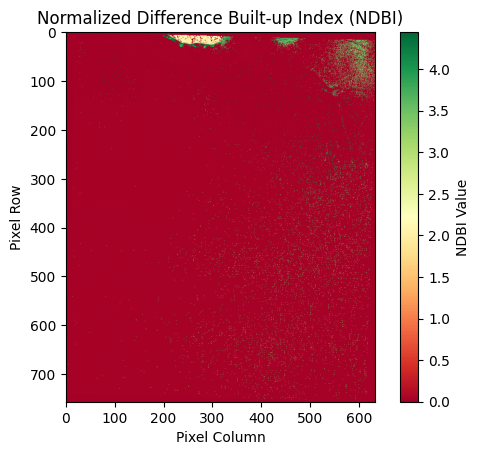

In [43]:
# NDBI calculation
nbdi = (swir_band - nir_band) / (swir_band + nir_band + 1e-6)

# Plot
plt.imshow(nbdi, cmap="RdYlGn")
plt.colorbar(label="NDBI Value")
plt.title("Normalized Difference Built-up Index (NDBI)")
plt.xlabel("Pixel Column")
plt.ylabel("Pixel Row")
plt.show()


In [ ]:
# Next Steps: 
# come up with a good system for caching the data
# desired granularity level for the data
